In [ ]:
!pip install spacy==3.0
!pip install nltk

# **Load Data**

In [ ]:
import pandas as pd


## Dataset is a list of speech given by each coountry in UN
url = 'https://github.com/Git-PratikVyas/NLP-TextAnalysis/blob/main/data/speech.csv.gz?raw=true'
df = pd.read_csv(url, compression='gzip')
df.head()

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."


In [ ]:
print(repr(df.iloc[0]["text"][0:200]))
#print(repr(df.iloc[-1]["text"][0:200]))

'33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work '


Split paragraph in a speech (text column)

In [ ]:
## split paragraph on full stop (.),exclamation (!)  or question mark (?) instead of new line (/n) character. 
#As /n is used to separate line and not para

import re

df["paragraphs"] = df["text"].map(lambda text:re.split('[.?!]\s*\n', text)) ## split paragraph on full stop (.),exclamation (!)  or question mark (?) 
df["number_of_paragraphs"] = df["paragraphs"].map(len) ## count para in each text

In [ ]:
df.head()

,session,year,country,country_name,speaker,position,text,paragraphs,number_of_paragraphs
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,[33: May I first convey to our President the c...,60
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...,[177.\t : It is a fortunate coincidence that p...,50
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...,[100.\t It is a pleasure for me to extend to ...,71
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...,[155.\t May I begin by expressing to Ambassad...,41
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ...","[176. No doubt each of us, before coming up to...",60


In [ ]:
##df["paragraphs"][0] ## 60 para in first speech

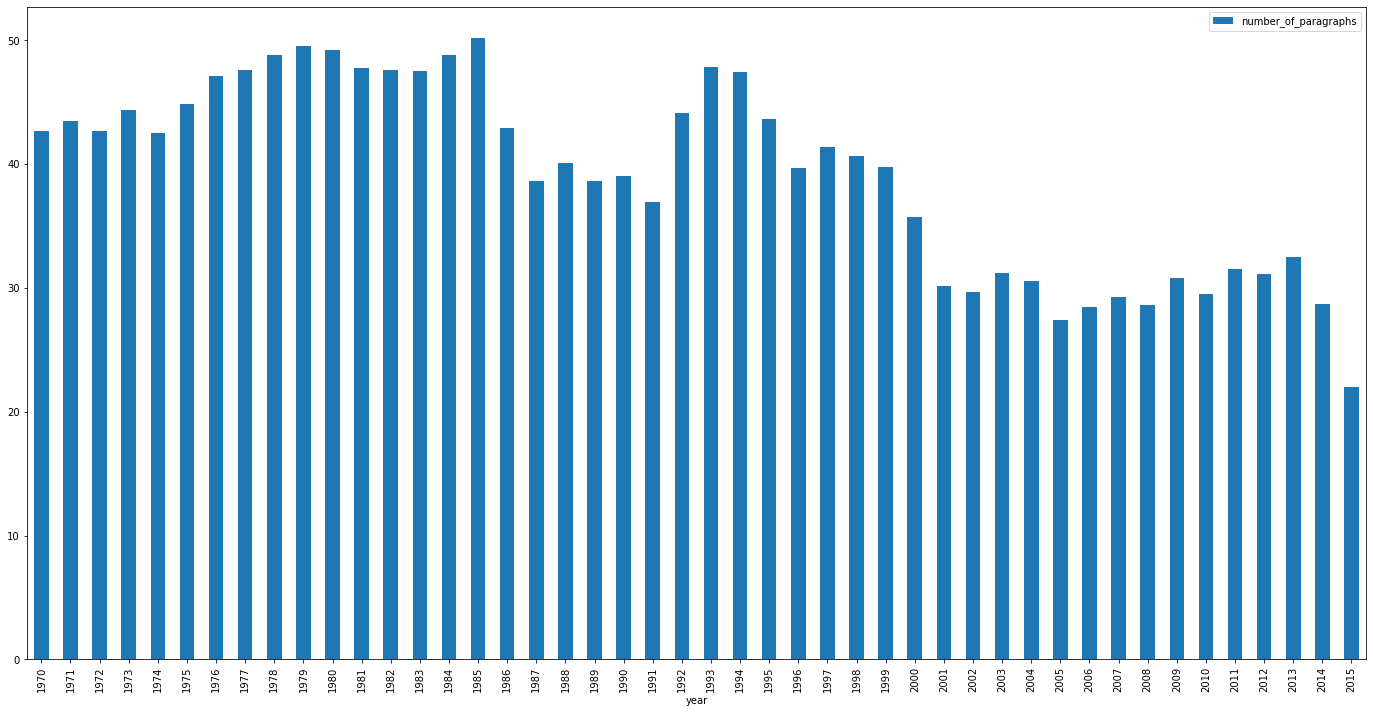

In [ ]:
## number of para per year

%matplotlib inline
df.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar(figsize=(24,12))

# **Calculate TF/IDF matrix**

It calculate Document-term matrix. 
where..
* matrix rows are documents. 
* matrix columns are tf/idf weighted word frequencies  

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [ ]:
## reduce feture by avoiding stopwords and check min-max frequency in doc

## tf/idf on speech
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


(7507, 24611)

In [ ]:
# flatten the paragraphs keeping the years
paragraph_year_df = pd.DataFrame([
                             { 
                                 "text": paragraph, "year": year 
                              } 
                               for paragraphs, year in zip(df["paragraphs"], df["year"]) 
                                    for paragraph in paragraphs if paragraph
                             ])

paragraph_year_df.head()

,text,year
0,33: May I first convey to our Presid...,1970
1,34.\tIn taking up the work on the ag...,1970
2,35.\tThe utilization of the United N...,1970
3,36.\tThe whole of progressive mankin...,1970
4,37.\tAll this has had well known con...,1970


In [ ]:
## tf/idf on paragraph

tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_year_df["text"])
tfidf_para_vectors.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


(282210, 25165)

# **Topic modelling using LSA (Latent Semantic Analysis) using tf/idf matrix**

LSA is based on singular value decomposition.


> It factor termXdocument matrix into three matrix V= U . E . V*

> V=  (term X documents) matrix . It is original corpus matrix

> U=  (topics X documents ) matrix

> E= digonal matrix containing singular values ( important topics digonally in  decending order ) 

> V*= (topics X terms ) matrix


In [ ]:
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_para_vectors) # <<=== tf/idf para vector
H_svd_para_matrix = svd_para_model.components_

In [ ]:
def display_topics(model, features, no_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]],
                  word_vector[largest[i]]*100.0/total))

In [ ]:
display_topics(svd_para_model, tfidf_para_vectorizer.get_feature_names())


Topic 00
  nations (0.67)
  united (0.65)
  international (0.58)
  peace (0.46)
  world (0.46)

Topic 01
  general (-14.04)
  assembly (-13.09)
  session (-12.94)
  mr (-10.02)
  president (-8.59)

Topic 02
  countries (19.15)
  development (14.61)
  economic (13.91)
  developing (13.00)
  session (10.29)

Topic 03
  nations (-4.41)
  united (-4.06)
  development (-0.95)
  organization (-0.84)
  charter (-0.80)

Topic 04
  nuclear (-21.13)
  weapons (-14.01)
  disarmament (-9.02)
  treaty (-7.23)
  proliferation (-6.31)

Topic 05
  rights (29.50)
  human (28.81)
  nuclear (9.20)
  weapons (6.42)
  respect (4.98)

Topic 06
  africa (8.73)
  south (8.24)
  united (3.91)
  african (3.71)
  nations (3.41)

Topic 07
  council (-14.96)
  security (-13.38)
  africa (-8.50)
  south (-6.11)
  african (-3.94)

Topic 08
  world (48.49)
  international (41.03)
  peace (32.98)
  community (23.27)
  africa (22.00)

Topic 09
  development (-63.98)
  sustainable (-20.78)
  peace (-20.74)
  goals (-15

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
svd_para_model.singular_values_

array([71.7166257 , 39.41222059, 36.59092542, 34.95099911, 33.35379448,
       31.56193554, 29.96968338, 28.79401884, 27.08035355, 26.8585253 ])

# **Topic modeling using LDA**

https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2


*   LDA (Latent Dirichlet Allocation ): 

from a given words , it calculate probability of topic , word distribution for each topic and mixture of topic within document

It assume topics are set of words and documents are mixture of topics


---



---



LDA views each document is a mix of different topics. In the same way, topics are mixed from words. To keep the number of topics per document low and to have only a few, important words constituting the topics, LDA initially uses a Dirichlet distribution( Dirichlet prior). This is applied both for assigning topics to documents and for finding words for the topics. The Dirichlet distribution ensures that documents have only a small number of topics and topics are mainly defined by a small number of words. 

After the initial assignments, the generative process starts. It uses the Dirichlet distributions for topics and words and tries to re-create the words from the original documents with stochastic sampling. This process has to be iterated many times and is therefore computationally intensive. On the other hand, the results can be used to generate documents for any identified topic.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


## CountVectorizer counting frequency of each words in corpus against each doc
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_year_df["text"])
count_para_vectors.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


(282210, 25165)

In [ ]:
##print(count_para_vectorizer.vocabulary_)

In [ ]:

print('The length of vocabulary', len(count_para_vectorizer.get_feature_names_out ()))

#Shape returned (282210, 25165) means 282210 rows(sentences) and 25165 columns(unique words)
print('The shape is', count_para_vectors.shape)

The length of vocabulary 25165
The shape is (282210, 25165)


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [ ]:
print(len(lda_para_model.components_))
print(lda_para_model.components_[0])

10
[1.00044376e-01 1.14109696e+03 1.00091990e-01 ... 2.27356725e+00
 1.00055940e-01 1.00001124e-01]


In [ ]:
display_topics(lda_para_model, count_para_vectorizer.get_feature_names())


Topic 00
  africa (2.38)
  people (1.86)
  south (1.57)
  namibia (0.88)
  regime (0.75)

Topic 01
  republic (1.52)
  government (1.39)
  united (1.21)
  peace (1.16)
  people (1.02)

Topic 02
  general (4.22)
  assembly (3.63)
  session (3.38)
  president (2.33)
  mr (2.32)

Topic 03
  human (3.62)
  rights (3.48)
  international (1.83)
  law (1.01)
  terrorism (0.99)

Topic 04
  world (2.22)
  people (1.14)
  countries (0.94)
  years (0.88)
  today (0.66)

Topic 05
  peace (1.76)
  security (1.63)
  east (1.34)
  middle (1.34)
  israel (1.24)

Topic 06
  countries (3.19)
  development (2.70)
  economic (2.22)
  developing (1.61)
  international (1.45)

Topic 07
  nuclear (3.14)
  weapons (2.32)
  disarmament (1.82)
  states (1.47)
  arms (1.46)

Topic 08
  nations (5.50)
  united (5.11)
  international (1.46)
  security (1.45)
  organization (1.44)

Topic 09
  international (1.96)
  world (1.91)
  peace (1.60)
  economic (1.00)
  relations (0.99)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([ 7.74149799, 10.78571462,  7.55770825,  7.73722598,  8.82209326,
        8.39012469, 13.8062732 ,  6.45160642, 15.66596763, 13.04178797])

# **Visualise Topics and word distribution**

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
lda_tsne_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False, mds='tsne')
pyLDAvis.display(lda_tsne_display)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model_1 = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix_1 = lda_para_model_1.fit_transform(tfidf_para_vectors) ## <<=== tfidf_para_vectors instead countvectorize_para_vectors
H_lda_para_matrix_1 = lda_para_model_1.components_

**Compare LSA vs LDA topics**

In [ ]:
print(display_topics(lda_para_model_1, tfidf_para_vectorizer.get_feature_names()) , #<<== LDA with tfidf_Vectorizer
      display_topics(lda_para_model, count_para_vectorizer.get_feature_names()), #<<== LDA with count_Vectorizer
      display_topics(svd_para_model, tfidf_para_vectorizer.get_feature_names()) # <<== LSA with SVD
      )


Topic 00
  people (0.63)
  world (0.62)
  poverty (0.55)
  children (0.51)
  war (0.45)

Topic 01
  peace (0.74)
  republic (0.59)
  united (0.50)
  region (0.49)
  government (0.44)

Topic 02
  mr (1.75)
  general (1.66)
  session (1.60)
  assembly (1.45)
  president (1.36)

Topic 03
  terrorism (1.00)
  rights (0.97)
  human (0.88)
  international (0.71)
  law (0.39)

Topic 04
  nations (0.95)
  united (0.89)
  council (0.79)
  security (0.60)
  world (0.58)

Topic 05
  people (0.73)
  africa (0.62)
  israel (0.57)
  south (0.56)
  palestinian (0.55)

Topic 06
  countries (1.35)
  economic (0.88)
  developing (0.84)
  development (0.75)
  trade (0.58)

Topic 07
  nuclear (2.48)
  weapons (1.86)
  disarmament (1.44)
  arms (1.08)
  treaty (0.93)

Topic 08
  nations (1.00)
  united (0.96)
  development (0.91)
  international (0.65)
  general (0.48)

Topic 09
  world (0.77)
  international (0.68)
  peace (0.60)
  nations (0.51)
  economic (0.46)

Topic 00
  africa (2.38)
  people (1.86

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Display Topics and important words using WordClouds**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


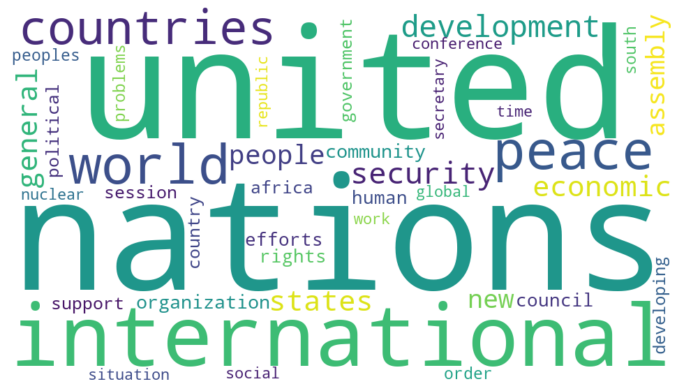

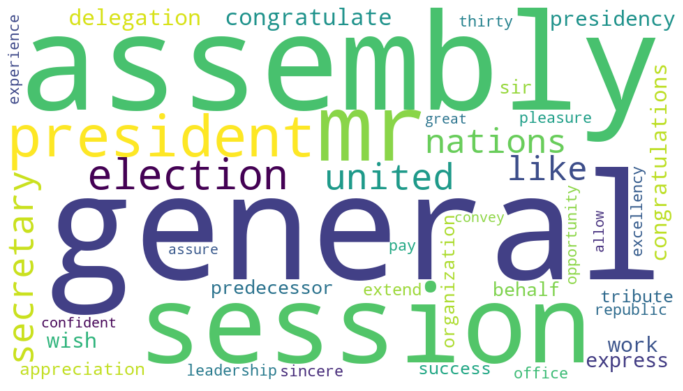

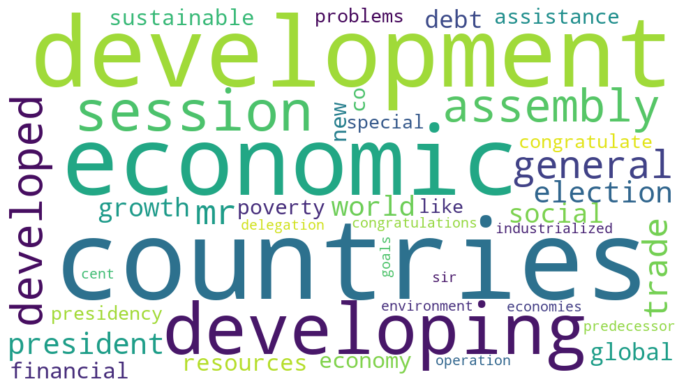

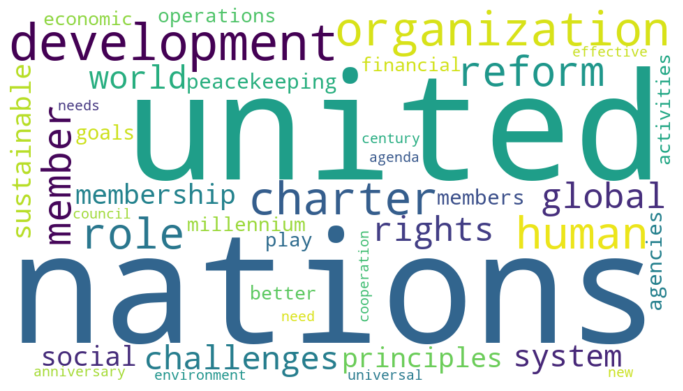

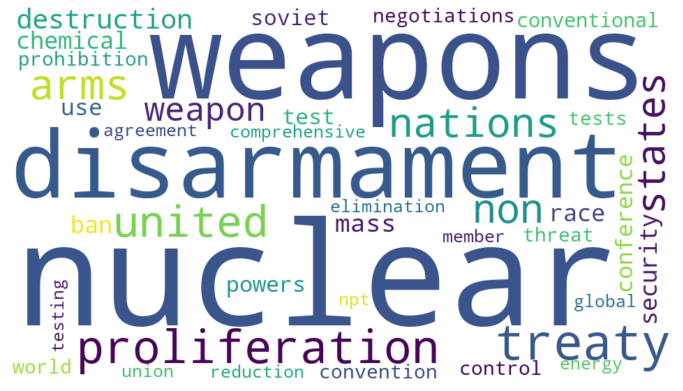

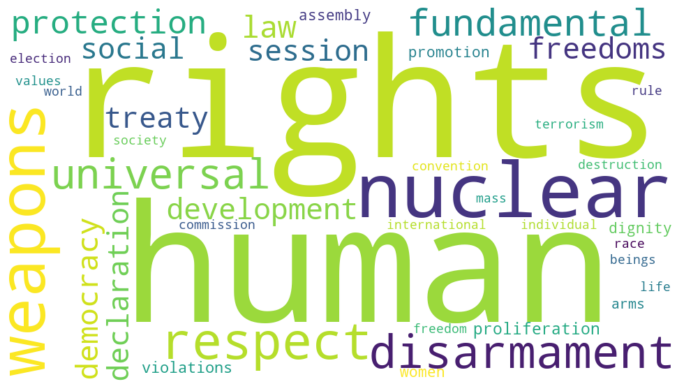

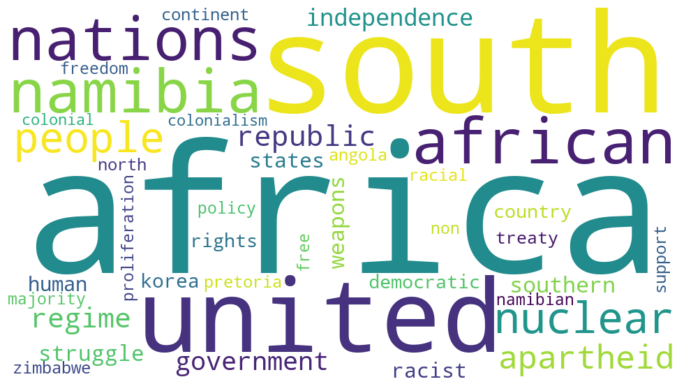

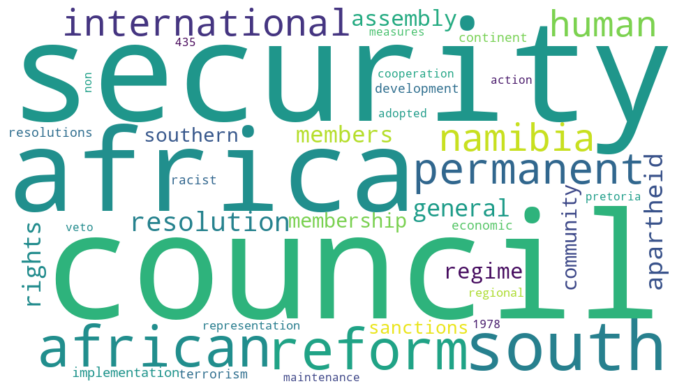

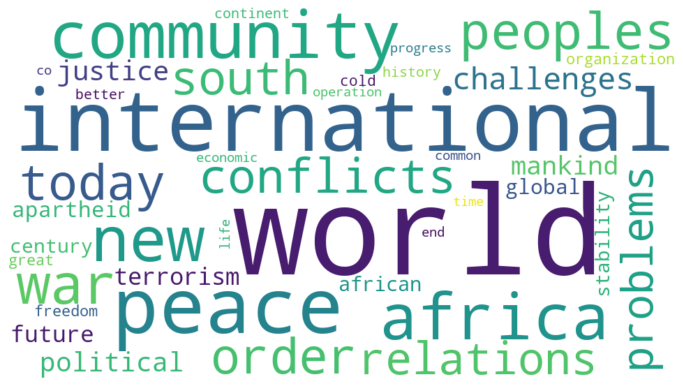

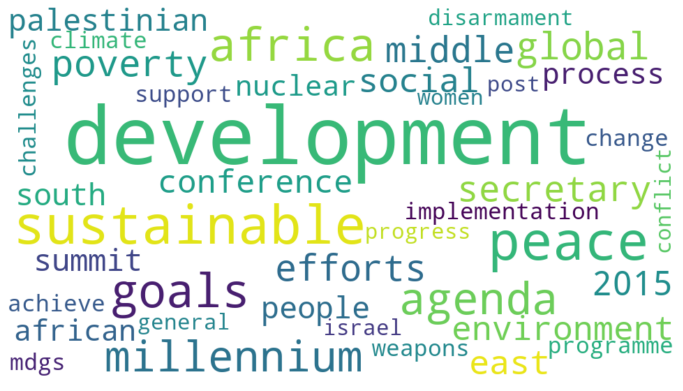

In [ ]:
wordcloud_topics(svd_para_model, tfidf_para_vectorizer.get_feature_names())

# **Topic modelling with Gensim**

In [ ]:
# create tokenized documents
gensim_paragraphs = [
                     [
                      w for w in re.findall(r'\b\w\w+\b' , paragraph.lower())
                          if w not in stopwords
                      ]
                             for paragraph in paragraph_year_df["text"]
                     ]

In [ ]:
print(gensim_paragraphs[0])
print(paragraph_year_df["text"][0])

['33', 'convey', 'president', 'congratulations', 'albanian', 'delegation', 'election', 'presidency', 'fifth', 'session', 'general', 'assembly']
33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly


In [ ]:
from gensim.corpora import Dictionary

##dictionary as a mapping from words to columns
## https://www.tutorialspoint.com/gensim/gensim_creating_a_dictionary.htm

dict_gensim_para = Dictionary(gensim_paragraphs) 

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
## just like tf/idf min_df and max_df
## ignore if word frequency is too less or too high
dict_gensim_para.filter_extremes(no_below=5, no_above=0.7)

In [ ]:
## calculate the bag-of-words matrix 

bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]

In [ ]:
len(bow_gensim_para)

282210

In [ ]:
from gensim.models import TfidfModel
tfidf_gensim_para = TfidfModel(bow_gensim_para)
vectors_gensim_para = tfidf_gensim_para[bow_gensim_para]

In [ ]:
!python -m pip install -U gensim

In [ ]:
from gensim.models.nmf import Nmf

nmf_gensim_para = Nmf(vectors_gensim_para, num_topics=10, id2word=dict_gensim_para, kappa=0.1, eval_every=5, random_state=42) 

In [ ]:
def display_topics_gensim(model):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=5):
            print("  %s (%2.2f)" % (word, prob))

In [ ]:
display_topics_gensim(nmf_gensim_para)


Topic 00
  nations (0.03)
  united (0.02)
  human (0.02)
  rights (0.02)
  role (0.01)

Topic 01
  africa (0.02)
  south (0.02)
  people (0.02)
  government (0.01)
  republic (0.01)

Topic 02
  economic (0.01)
  development (0.01)
  countries (0.01)
  social (0.01)
  international (0.01)

Topic 03
  countries (0.02)
  developing (0.02)
  resources (0.01)
  sea (0.01)
  developed (0.01)

Topic 04
  israel (0.02)
  arab (0.02)
  palestinian (0.02)
  council (0.01)
  security (0.01)

Topic 05
  organization (0.02)
  charter (0.02)
  principles (0.01)
  member (0.01)
  international (0.01)

Topic 06
  problem (0.01)
  solution (0.01)
  east (0.01)
  situation (0.01)
  problems (0.01)

Topic 07
  nuclear (0.02)
  co (0.02)
  operation (0.02)
  weapons (0.02)
  disarmament (0.02)

Topic 08
  session (0.02)
  general (0.02)
  assembly (0.02)
  mr (0.02)
  president (0.02)

Topic 09
  world (0.02)
  peace (0.02)
  peoples (0.02)
  security (0.01)
  states (0.01)


# **Topic Coherence**

It evaluate quality of topic

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

https://radimrehurek.com/gensim/models/coherencemodel.html

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. 

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

nmf_gensim_para_coherence = CoherenceModel(model=nmf_gensim_para, texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')
nmf_gensim_para_coherence_score = nmf_gensim_para_coherence.get_coherence()
print(nmf_gensim_para_coherence_score)

0.6467537513587844


**Optimise number of LDA topic**

In [ ]:
## it is time consuming hence set param as per requirement. 

from gensim.models.ldamulticore import LdaMulticore
from tqdm import tqdm

lda_para_model_n = []
for n in tqdm(range(5, 15)): ## <<===set this range as per requirement
    ## parallelized Latent Dirichlet Allocation https://radimrehurek.com/gensim/models/ldamulticore.html
    lda_model = LdaMulticore(corpus=bow_gensim_para, id2word=dict_gensim_para, chunksize=2000,
                             eta='auto', iterations=4, ## <<===set iteration as per requirement
                             num_topics=n, passes=2, ## <<===set passes as per requirement
                             eval_every=None, random_state=42)
    
    lda_coherence = CoherenceModel(model=lda_model, texts=gensim_paragraphs, 
                                   dictionary=dict_gensim_para, coherence='c_v')
    
    lda_para_model_n.append((n, lda_model, lda_coherence.get_coherence()))

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  logger.info('initializing workers')
100%|██████████| 10/10 [26:12<00:00, 157.21s/it]


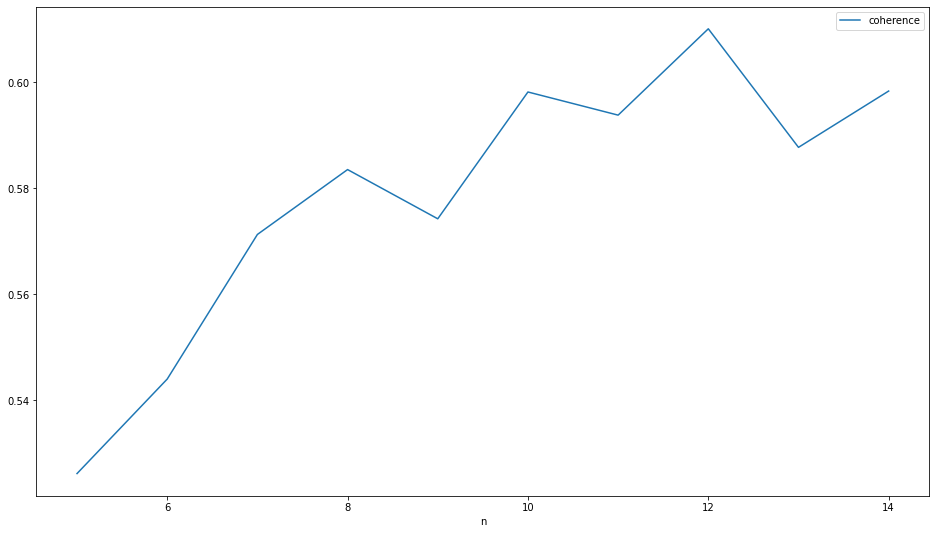

In [ ]:
##we can see spikes at 10 and 12 topics, so these numbers are good choices
pd.DataFrame(lda_para_model_n, columns=["n", "model", "coherence"]).set_index("n")[["coherence"]].plot(figsize=(16,9))

we can see spikes at 10 and 12 topics, so these numbers are good choices